In [2]:
%matplotlib inline


from importlib import reload

from scipy import signal, stats, spatial, ndimage

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs
import TreeMazeAnalyses2.Analyses.TreeMazeFunctions as tmf

from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)

from ipywidgets import interact, fixed
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from TreeMazeAnalyses2.Analyses import subject_info as si

si = reload(si)
session = 'Li_T3g_070618'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

In [6]:
if 0:
    subject_info = si.SubjectInfo(subject, overwrite=True)
    session_info = si.SubjectSessionInfo(subject, session)

Error Computing Cluster Stats for Li_OF_052818


In [4]:
tmf = reload(tmf)
o=tmf.getBehTrackData(session_info)

Loading Beh Tracking Data
Complete.


In [5]:
o.keys()

dict_keys(['EventDat', 'HeadingAng', 'InSeg', 'OutSeg', 'PosMat', 'PosZones', 'SegDirMat', 'SegDirSeq', 'Speed', 'step', 't', 'tB', 'tE', 'x', 'y'])

In [6]:
type(o['HeadingAng'])

numpy.ndarray

## Check zones

In [16]:
import Analyses.plot_functions as pf
from shapely.geometry.polygon import Polygon

In [732]:
MazeZonesCoords = {'Home': [(-300, -80), (-300, 80), (300, 80), (300, -80)],
                   'Center': [(-80, 500), (-95, 400), (-150, 400), (-150, 655),
                              (-75, 550), (0, 600), (75, 550), (150, 660), (150, 400),
                              (95, 400), (80, 500)],
                   'SegA': [(-150, 80), (-80, 500), (80, 500), (150, 80)],
                   'SegB': [(0, 600), (0, 700), (200, 1000), (330, 900), (75, 550)],
                   'SegC': [(610, 1180), (610, 800), (329, 900), (450, 1180)], # changed from 330->329
                   'SegD': [(200, 1000), (50, 1230), (450, 1230), (450, 1180)],
                   'SegE': [(0, 600), (0, 700), (-200, 1000), (-330, 900), (-75, 550)],
                   'SegF': [(-200, 1000), (-50, 1230), (-450, 1230), (-450, 1180)],
                   'SegG': [(-610, 1180), (-610, 800), (-329, 900), (-450, 1180)], # changed from 330->329

                   'G1': [(610, 1180), (800, 1180), (800, 800), (610, 800)],
                   'G2': [(50, 1230), (50, 1450), (450, 1450), (450, 1230)],
                   'G3': [(-50, 1230), (-50, 1450), (-450, 1450), (-450, 1230)],
                   'G4': [(-610, 1180), (-800, 1180), (-800, 800), (-610, 800)],

                   'I1': [(200, 1000), (450, 1180), (330, 900)],
                   'I2': [(-330, 900), (-450, 1180), (-200, 1000)],
                   }

ZonesNames = list(MazeZonesCoords.keys())
MazeZonesGeom = {}
for zo in MazeZonesCoords.keys():
    MazeZonesGeom[zo] = Polygon(MazeZonesCoords[zo])

Text(-250, 1300, 'G3')

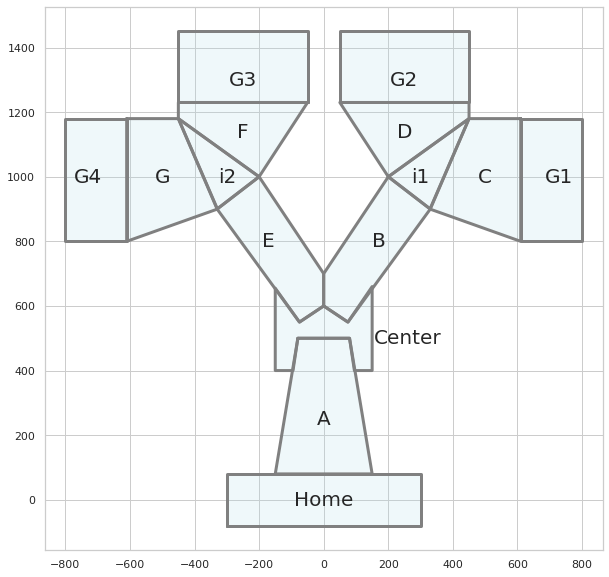

In [733]:
f,ax = plt.subplots(figsize=(10,10))
for zo in MazeZonesGeom.keys():
    pf.plotPoly(MazeZonesGeom[zo],ax,alpha=0.2,color='powderblue',lw=3)
ax.axis('equal')

ax.text(0,0,'Home',horizontalalignment='center',verticalalignment='center')
ax.text(0,250,'A',horizontalalignment='center',verticalalignment='center')
ax.text(155,500,'Center',horizontalalignment='left',verticalalignment='center')

ax.text(170,800,'B',horizontalalignment='center',verticalalignment='center')
ax.text(-170,800,'E',horizontalalignment='center',verticalalignment='center')

ax.text(300,1000,'i1',horizontalalignment='center',verticalalignment='center')
ax.text(-300,1000,'i2',horizontalalignment='center',verticalalignment='center')

ax.text(500,1000,'C',horizontalalignment='center',verticalalignment='center')
ax.text(-500,1000,'G',horizontalalignment='center',verticalalignment='center')

ax.text(730,1000,'G1',horizontalalignment='center',verticalalignment='center')
ax.text(-730,1000,'G4',horizontalalignment='center',verticalalignment='center')

ax.text(250,1140,'D',horizontalalignment='center',verticalalignment='center')
ax.text(-250,1140,'F',horizontalalignment='center',verticalalignment='center')

ax.text(250,1300,'G2',horizontalalignment='center',verticalalignment='center')
ax.text(-250,1300,'G3',horizontalalignment='center',verticalalignment='center')

In [535]:
class Points2D:
    def __init__(self, x, y, polar=False):

        if not isinstance(x, np.ndarray):
            x = np.array([x]).flatten()
        if not isinstance(y, np.ndarray):
            y = np.array([y]).flatten()

        assert len(x) == len(y), 'different lengths'

        self.n = len(x)
        if not polar:
            self.x = np.array(x)
            self.y = np.array(y)
            self.xy = np.column_stack((self.x, self.y))
            self.r, self.ang = self.polar()
        else:
            self.r = x
            self.ang = np.mod(y, 2 * np.pi)
            self.x, self.y = self.eu()
            self.xy = np.column_stack((self.x, self.y))

    def polar(self):
        r = np.sqrt(self.x ** 2 + self.y ** 2)
        ang = np.zeros(self.n)

        for ii in range(self.n):
            ang[ii] = np.math.atan2(self.y[ii], self.x[ii])
        ang = np.mod(ang, 2 * np.pi)
        return r, ang

    def eu(self):
        x = self.r * np.cos(self.ang)
        y = self.r * np.sin(self.ang)
        return x, y
    
    def half_ang(self):
        ang2 = np.array(self.ang)
        ang2[ang2>np.pi] = np.mod(ang2[ang2>np.pi], -np.pi)
        return ang2

    def __add__(self, b):
        if isinstance(b, (int, float)):
            return Points2D(self.x + b, self.y + b)

        if isinstance(b, Points2D):
            return Points2D(self.x + b.x, self.y + b.y)
        else:
            raise NotImplementedError

    def __sub__(self, b):
        if isinstance(b, (int, float)):
            return Points2D(self.x - b, self.y - b)

        if isinstance(b, Points2D):
            return Points2D(self.x - b.x, self.y - b.y)
        else:
            raise NotImplementedError

    def __rsub__(self, b):
        if isinstance(b, (int, float)):
            return Points2D(b - self.x, b - self.y)

        if isinstance(b, Points2D):
            return Points2D(b.x - self.x, b.y - self.y)
        else:
            raise NotImplementedError

    def __mul__(self, b):
        if isinstance(b, (int, float, np.float, np.int)):
            return Points2D(b * self.x, b * self.y)

        if isinstance(b, Points2D):
            return b.x @ self.x + b.y @ self.y
        else:
            raise NotImplementedError

    def __rmul__(self, b):
        if isinstance(b, (int, float, np.float, np.int)):
            return Points2D(b * self.x, b * self.y)
        elif isinstance(b, Points2D):
            if self.n == b.n:
                return Points2D(b.x * self.x, b.y @ self.y)
            if self.n == 1 or b.n == 1:
                return
        else:
            raise NotImplementedError
            
    def __truediv__(self,b):
        return Points2D(self.r/b, self.ang, polar=True)
    
    def __rdiv__(self,b):
        return Points2D(self.r/b, self.ang, polar=True)

    def __getitem__(self, i):
        if isinstance(i, (int, np.int, np.ndarray)):
            return Points2D(self.x[i], self.y[i])
        else:
            raise NotImplementedError

    def __len__(self):
        return self.n

    def __str__(self):
        print((self.x, self.y))
        return ''
    
    def _repr_html_(self):
        print(self.xy)
        return ''

def deg_full_2_half(th):
    th2 = np.array(th)
    th2[th>np.pi] = np.mod(th2[th>np.pi], -np.pi)
    return th2

In [196]:
b = Points2D(200,1000)
c = Points2D(330,900)
w = (b-c).r[0]

d = Points2D(75,550)
l = (c-d).r[0]
dc = c-d

wx = c.x-b.x
wy = b.y-c.y

a = Points2D(d.x-wx, d.y+wy)

n_SegB_subsegs = int(l//subseg_len_mm)
delta = l/n_SegB_subsegs

SegB =  MazeZonesGeom['SegB']
SegB_subsegs = np.zeros(n_SegB_subsegs,dtype=object)
for ii in range(n_SegB_subsegs):
    p0 = Points2D(ii*delta, dc.ang, polar=True)+a
    p1 = Points2D((ii+1)*delta, dc.ang, polar=True)+a
    p2 = Points2D((ii+1)*delta, dc.ang, polar=True)+d
    p3 = Points2D(ii*delta, dc.ang, polar=True)+d
    
    subseg = Polygon([p0.xy[0],
                      p1.xy[0], 
                      p2.xy[0], 
                      p3.xy[0]])
    SegB_subsegs[ii] = SegB.intersection(subseg)

In [736]:
def divide_seg(seg, subseg_length, orientation='v'):
    
    # bounding rectangle coords
    xx, yy = seg.minimum_rotated_rectangle.exterior.xy
    xx = xx[:4]
    yy = yy[:4]
    pp = Points2D(xx,yy)
    
    # center coords
    cc = np.array(seg.centroid.coords)[0]
    cp = Points2D(cc[0],cc[1])
    
    centered_pp = pp-cp
    coord_cen_ang = centered_pp.half_ang()
    min_ang_coord = np.argmin(np.abs(coord_cen_ang))
    
    if coord_cen_ang[min_ang_coord]<0:
        min_ang_coord+=1
    
    # circle coordinates to start at the min angle
    rpp = np.roll(pp.xy, -min_ang_coord, axis=0) 
    pp = Points2D(rpp[:,0], rpp[:,1])


    # 
    if orientation == 'v':
        L = pp[0]-pp[3]
        a = pp[2]
        b = pp[3]
    else:
        L = pp[1] - pp[0]
        a = pp[0]
        b = pp[3]
        
    n_subsegs = int(L.r//subseg_length)

    delta = L.r/n_subsegs
    subsegs = np.zeros(n_subsegs,dtype=object)
    
    for ii in range(n_subsegs):
        
        p0 = Points2D(ii*delta, L.ang, polar=True)+a
        p1 = Points2D((ii+1)*delta, L.ang, polar=True)+a
        p2 = Points2D((ii+1)*delta, L.ang, polar=True)+b
        p3 = Points2D(ii*delta, L.ang, polar=True)+b

        subseg = Polygon([p0.xy[0],
                          p1.xy[0], 
                          p2.xy[0], 
                          p3.xy[0]])
        
        subsegs[ii] = seg.intersection(subseg)
    return subsegs

def divide_seg2(seg, subseg_length, direction='N'):
    
    dir_dict = {a:b for a,b in zip(['E','N','W','S'],range(1,5))}
    # bounding rectangle coords
    xx, yy = seg.minimum_rotated_rectangle.exterior.xy
    pp = Points2D(xx,yy)

    l_segs = np.diff(pp.xy,axis=0)
    l_segs_v = Points2D(l_segs[:,0],l_segs[:,1])

    l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi/4,2*np.pi +np.pi/4+0.001 ,np.pi/2 ))
    l_segs_dirs[l_segs_dirs==5]=1
    
    l_dir_id = np.where(l_segs_dirs==dir_dict[direction])[0][0]

    L = l_segs[l_dir_id]
    L = Points2D(L[0], L[1])

    a = pp.xy[:4][l_dir_id-1]
    a = Points2D(a[0],a[1])
    b = pp.xy[:4][l_dir_id]
    b = Points2D(b[0],b[1])


    n_subsegs = int(L.r//subseg_length)

    delta = L.r/n_subsegs
    subsegs = np.zeros(n_subsegs,dtype=object)
    
    for ii in range(n_subsegs):
        
        p0 = Points2D(ii*delta, L.ang, polar=True)+a
        p1 = Points2D((ii+1)*delta, L.ang, polar=True)+a
        p2 = Points2D((ii+1)*delta, L.ang, polar=True)+b
        p3 = Points2D(ii*delta, L.ang, polar=True)+b

        subseg = Polygon([p0.xy[0],
                          p1.xy[0], 
                          p2.xy[0], 
                          p3.xy[0]])
        
        subsegs[ii] = seg.intersection(subseg)
    return subsegs

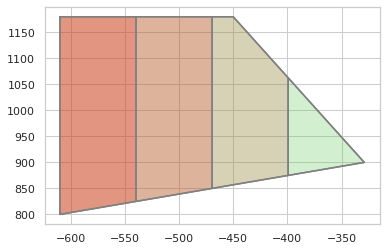

In [735]:
segName = 'SegG'
seg = MazeZonesGeom[segName]
subseg_length = 60

if segName[3] == 'C':
    d = 'E'
    sb = divide_seg2(seg, subseg_length, direction=d)
elif segName[3] == 'G':
    d='W'
    sb = divide_seg2(seg, subseg_length, direction=d)
else:
    d='N'
    sb = divide_seg2(seg, subseg_length, direction=d)
    
n_segs = len(sb)
    
f,ax=plt.subplots()
pf.plotPoly(seg,ax)    
for ii in range(n_segs):
    pf.plotPoly(sb[ii],ax, alpha=0.5*ii/n_segs,color='red')
    
dir_dict = {a:b for a,b in zip(['E','N','W','S'],range(1,5))}
# bounding rectangle coords
xx, yy = seg.minimum_rotated_rectangle.exterior.xy

pp = Points2D(xx,yy)

l_segs = np.diff(pp.xy,axis=0)
l_segs_v = Points2D(l_segs[:,0],l_segs[:,1])

l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi/4,2*np.pi +np.pi/4+0.001 ,np.pi/2 ))
l_segs_dirs[l_segs_dirs==5]=1

l_dir_id = np.where(l_segs_dirs==dir_dict[d])[0][0]

L = l_segs[l_dir_id]
L = Points2D(L[0], L[1])

a = pp.xy[:4][l_dir_id-1]
a = Points2D(a[0],a[1])
b = pp.xy[:4][l_dir_id]
b = Points2D(b[0],b[1])

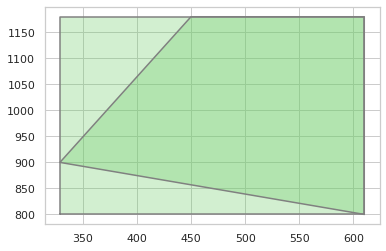

In [730]:
seg = Polygon([(610, 800),(610, 1180), (450, 1180), (329, 900)])

f,ax=plt.subplots()
pf.plotPoly(seg,ax)   
pf.plotPoly(seg.minimum_rotated_rectangle,ax)

In [685]:
direction = 'E'

dir_dict = {a:b for a,b in zip(['E','N','W','S'],range(1,5))}
# bounding rectangle coords
xx, yy = seg.minimum_rotated_rectangle.exterior.xy

pp = Points2D(xx,yy)

l_segs = np.diff(pp.xy,axis=0)
l_segs_v = Points2D(l_segs[:,0],l_segs[:,1])

l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi/4,2*np.pi +np.pi/4+0.001 ,np.pi/2 ))
l_segs_dirs[l_segs_dirs==5]=1

l_dir_id = np.where(l_segs_dirs==dir_dict[d])[0][0]

L = l_segs[l_dir_id]
L = Points2D(L[0], L[1])

a = pp.xy[:4][l_dir_id-1]
a = Points2D(a[0],a[1])
b = pp.xy[:4][l_dir_id]
b = Points2D(b[0],b[1])



In [690]:
l_segs_dirs, np.rad2deg(l_segs_v.ang), L.ang

(array([3, 4, 1, 2]),
 array([160.34617594, 250.34617594, 340.34617594,  70.34617594]),
 array([5.94016137]))

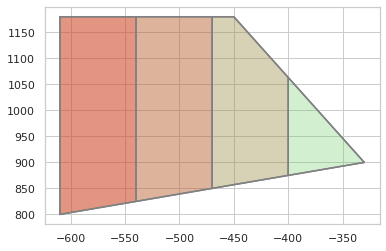

In [712]:

segName = 'SegG'

seg = MazeZonesGeom[segName]
if segName[3] == 'C':
    d = 'E'
    sb = divide_seg2(seg, subseg_length, direction=d)
elif segName[3] == 'G':
    d='W'
    sb = divide_seg2(seg, subseg_length, direction=d)
else:
    d='N'
    sb = divide_seg2(seg, subseg_length, direction=d)
    
n_segs = len(sb)
    
f,ax=plt.subplots()
pf.plotPoly(seg,ax)    
for ii in range(n_segs):
    pf.plotPoly(sb[ii],ax, alpha=0.5*ii/n_segs,color='red')
    

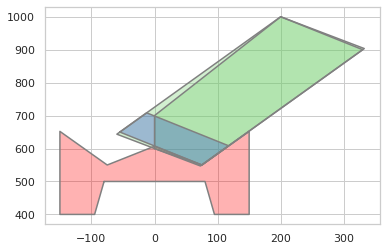

In [275]:
f,ax=plt.subplots()
pf.plotPoly(SegB,ax)
pf.plotPoly(subseg, ax, color='blue', alpha=0.3)
pf.plotPoly(MazeZonesGeom['Center'],ax, color='red')
pf.plotPoly(SegB.minimum_rotated_rectangle,ax)

(-880.0, 880.0, -156.5, 1526.5)

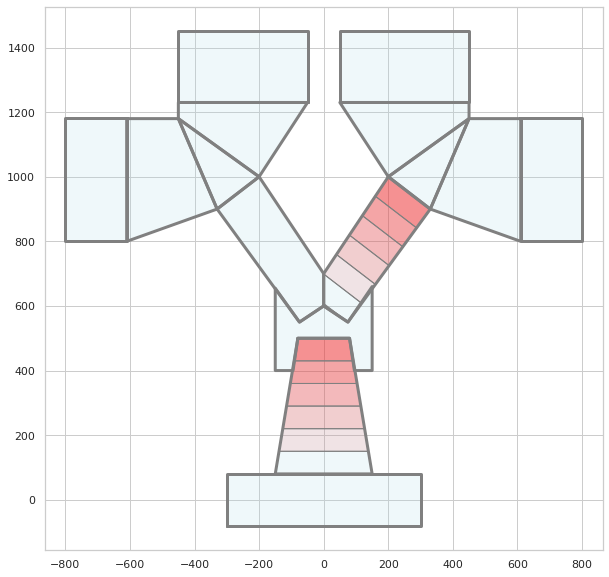

In [197]:
f,ax = plt.subplots(figsize=(10,10))
for zo in MazeZonesGeom.keys():
    pf.plotPoly(MazeZonesGeom[zo],ax,alpha=0.2,color='powderblue',lw=3)
    
    
    if zo == 'SegA':
        for ii in range(n_SegA_subsegs):
            pf.plotPoly(SegA_subsegs[ii],ax,alpha=0.5*ii/n_SegA_subsegs,color='red',lw=1)
    if zo == 'SegB':
        for ii in range(n_SegB_subsegs):
            pf.plotPoly(SegB_subsegs[ii],ax,alpha=0.5*ii/n_SegB_subsegs,color='red',lw=1)
ax.axis('equal')

## right upper corner correction for center

In [231]:
m=(c.y-d.y)/(c.x-d.x)
b = -m*c.x+c.y
int(b+m*150) 

652

## center correction

In [232]:
m=(a.y-d.y)/(a.x-d.x)
b = -m*a.x+a.y
int(b) 


607

## correction for sgments C and G
Change coords to start at 329 instead of 330 (error related to shapely min_rotated_rectanlge and creating subsegments).

# New Coordinates

In [770]:
MazeZonesCoords = {'Home': [(-300, -80), (-300, 80), (300, 80), (300, -80)],
                   'Center': [(-80, 500), (-95, 400), (-150, 400), (-150, 652),
                              (-75, 550), (0, 607), (75, 550), (150, 652), (150, 400),
                              (95, 400), (80, 500)],
                   'SegA': [(-150, 80), (-80, 500), (80, 500), (150, 80)],
                   'SegB': [(0, 607), (0, 700), (200, 1000), (329, 900), (75, 550)],
                   'SegC': [(610, 1180), (610, 800), (329, 900), (450, 1180)],
                   'SegD': [(200, 1000), (50, 1230), (450, 1230), (450, 1180)],
                   'SegE': [(0, 607), (0, 700), (-200, 1000), (-329, 900), (-75, 550)],
                   'SegF': [(-200, 1000), (-50, 1230), (-450, 1230), (-450, 1180)],
                   'SegG': [(-610, 1180), (-610, 800), (-329, 900), (-450, 1180)],

                   'G1': [(610, 1180), (800, 1180), (800, 800), (610, 800)],
                   'G2': [(50, 1230), (50, 1450), (450, 1450), (450, 1230)],
                   'G3': [(-50, 1230), (-50, 1450), (-450, 1450), (-450, 1230)],
                   'G4': [(-610, 1180), (-800, 1180), (-800, 800), (-610, 800)],

                   'I1': [(200, 1000), (450, 1180), (329, 900)],
                   'I2': [(-329, 900), (-450, 1180), (-200, 1000)],
                   }

ZonesNames = list(MazeZonesCoords.keys())
MazeZonesGeom = {}
for zo in ZonesNames:
    MazeZonesGeom[zo] = Polygon(MazeZonesCoords[zo])
    
out_dirs = {'SegA':'N', 
            'SegB':'N', 'SegC':'E', 'SegD':'N',
            'SegE':'N', 'SegF':'N', 'SegG':'W'}
in_dirs = {'SegA':'S', 
           'SegB':'S', 'SegC':'W', 'SegD':'S',
           'SegE':'S', 'SegF':'S', 'SegG':'E'}

In [1]:
plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.solid_capstyle'] = 'round'
f,ax = plt.subplots(figsize=(10,10))


for zo in MazeZonesGeom.keys():
    
    seg=MazeZonesGeom[zo]
    pf.plotPoly(seg,ax,alpha=0.2,color='powderblue',lw=2)
    
    if zo in out_dirs:
        sb = divide_seg2(seg, subseg_length, direction=out_dirs[zo])

        n_segs = len(sb)
        for ii in range(n_segs):
            #if zo=='SegG':
            pf.plotPoly(sb[ii],ax, alpha=0.5*ii/n_segs,color='red',lw=0)
        
ax.axis('equal')

NameError: name 'plt' is not defined

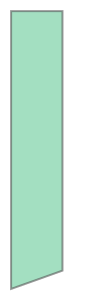